In [1]:
import os
from time import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data

In [3]:
# Only to fix the Mac's problem
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [4]:
class Generator(nn.Module):

    def __init__(self, d=64):
        super().__init__()

        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 0)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        # self.conv8_bn = nn.BatchNorm2d(d * 8)

        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 0)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 1, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))
        # e8 = self.conv8_bn(self.conv8(F.leaky_relu(e7, 0.2)))

        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = torch.tanh(d8)

        return o


class Discriminator(nn.Module):
    def __init__(self, d=64):
        super().__init__()
        self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [5]:
def compare_imgs(img_true, img_rec, verbose=True):

    assert img_true.shape == img_rec.shape
    if len(img_true.shape) == 3:
        assert img_true.shape[0] == 1

        img_true = img_true[0]
        img_rec = img_rec[0]

    img_true = img_true.numpy() if isinstance(img_true, torch.Tensor) else img_true
    img_rec = img_rec.numpy() if isinstance(img_rec, torch.Tensor) else img_rec

    mae = mean_absolute_error(img_true, img_rec)
    psnr = compare_psnr(img_true, img_rec)
    ssim = compare_ssim(img_true, img_rec)

    if verbose:
        print('\tMAE\tPSNR\tSSIM')
        print(f'score\t{mae:.3f}\t{psnr:.3f}\t{ssim:.3f}')

    return [mae, psnr, ssim]


def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)

In [6]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_TEST = 'data/ax_t2_single_source_test'
PATH_TO_SAMPLED_TRAIN = 'data/ax_t2_single_sampled_x2_train'
PATH_TO_SAMPLED_TEST = 'data/ax_t2_single_sampled_x2_test'

RANDOM_STATE = 42

In [7]:
class fastMRIData(torch_data.Dataset):
    def __init__(self, path_to_source, path_to_sampled):
        super().__init__()

        self.path_to_source = path_to_source
        self.path_to_sampled = path_to_sampled

        source_images = set(os.listdir(path_to_source))
        sampled_images = set(os.listdir(path_to_sampled))
        intersected_images = source_images.intersection(sampled_images)
        images = sorted([img for img in intersected_images if img.endswith('npy')])

        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        source_image = npy_load(os.path.join(self.path_to_source, self.images[idx]))
        sampled_image = npy_load(os.path.join(self.path_to_sampled, self.images[idx]))

        source_image = torch.from_numpy(source_image)
        sampled_image = torch.from_numpy(sampled_image)

        return source_image, sampled_image

In [8]:
fmri_train = fastMRIData(PATH_TO_SOURCE_TRAIN, PATH_TO_SAMPLED_TRAIN)
fmri_test = fastMRIData(PATH_TO_SOURCE_TEST, PATH_TO_SAMPLED_TEST)

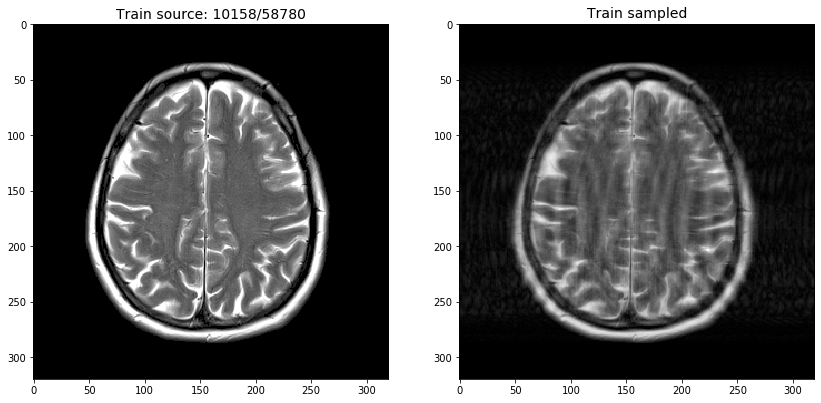

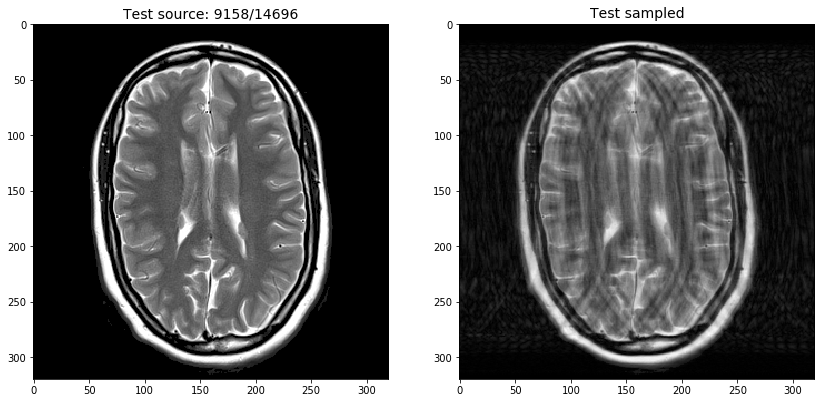

In [9]:
for fmri, type in zip([fmri_train, fmri_test], ['Train', 'Test']):

    i = np.random.randint(0, len(fmri))
    source, sampled = fmri_train.__getitem__(i)

    fig, axis = plt.subplots(1, 2, figsize=(14, 12))
    axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title(f'{type} source: {i+1}/{len(fmri)}', fontsize=14)
    axis[1].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
    axis[1].set_title(f'{type} sampled', fontsize=14)
    plt.show()

## Training

In [10]:
torch.manual_seed(RANDOM_STATE)

G = Generator(64)
D = Discriminator(64)

G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

l1_lambda = 100
lr = 0.0002
betas = (0.5, 0.999)

G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

train_loader = torch_data.DataLoader(fmri_train, batch_size=1, shuffle=True) 
test_loader = torch_data.DataLoader(fmri_test, batch_size=1000, shuffle=False) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [11]:
def discriminator_loss(sampled, source, G, D):
    D_result = D(sampled, source).squeeze()
    true_answers = torch.ones(D_result.size()).to(device)

    D_real_loss = F.binary_cross_entropy(D_result, true_answers)

    generated = G(sampled)
    D_result = D(sampled, generated).squeeze()
    false_answers = torch.zeros(D_result.size()).to(device)

    D_fake_loss = F.binary_cross_entropy(D_result, false_answers)

    loss = (D_real_loss + D_fake_loss) / 2
    return loss


def train_discriminator(sampled, source, G, D, D_optimizer):
    D.zero_grad()

    loss = discriminator_loss(sampled, source, G, D)

    loss.backward()
    D_optimizer.step()

    return loss


def generator_loss(sampled, source, G, D, l1_lambda):
    generated = G(sampled)
    D_result = D(sampled, generated).squeeze()
    true_answers = torch.ones(D_result.size()).to(device)

    loss = F.binary_cross_entropy(D_result, true_answers) + l1_lambda*F.l1_loss(generated, source)
    return loss


def train_generator(sampled, source, G, D, l1_lambda, G_optimizer):
    G.zero_grad()

    loss = generator_loss(sampled, source, G, D, l1_lambda)

    loss.backward()
    G_optimizer.step()

    return loss


def pix2pix_train(epochs, G, D, G_optimizer, D_optimizer, l1_lambda, device,
                  train_loader, val_loader, scheduler=None, verbose=True):

    G.to(device)
    D.to(device)

    for epoch in range(1, epochs+1):

        epoch_start = time()
        G.train()
        D.train()
        for source, sampled in train_loader:
            source = source.to(device)
            sampled = sampled.to(device)

            discriminator_train_loss = train_discriminator(sampled, source, G, D, D_optimizer)
            generator_train_loss = train_generator(sampled, source, G, D, l1_lambda, G_optimizer)

        train_time = time() - epoch_start

        G.eval()
        D.eval()
        for source, sampled in val_loader:
            source = source.to(device)
            sampled = sampled.to(device)

            discriminator_val_loss = discriminator_loss(sampled, source, G, D)
            generator_val_loss = generator_loss(sampled, source, G, D, l1_lambda)
            break

        if scheduler is not None:
            scheduler.step()

        freq = max(epochs // 20, 1)
        if verbose and epoch%freq == 0:
            print(f'Epoch {epoch}/{epochs}\tTrain loss: [Discr: {discriminator_train_loss:.4f},', end=' ')
            print(f'Gen: {generator_train_loss:.4f}],  Val loss: [', end='')
            print(f'Dis: {discriminator_val_loss:.4f}, Gen: {generator_val_loss:.4f}] | {train_time:.1f} sec')

In [ ]:
epochs = 10
pix2pix_train(epochs, G, D, G_optimizer, D_optimizer, l1_lambda, device, train_loader, test_loader)